In [2]:
%matplotlib inline 

import pickle
import re
import json

import numpy as np
import pandas as pd
import requests
import seaborn as sns

sns.set_style('white')

In [3]:
with open('element_data.pickle', 'rb') as f:
    a = pickle.load(f)

In [4]:
type(a)

dict

In [5]:
a['lithium'][0]

,nuclide symbol,Z(p),N(n),isotopic mass (u),half-life,decay mode(s),daughter isotope(s),nuclear spin,representative isotopic composition (mole fraction),range of natural variation (mole fraction)
0,None,None,None,None,None,None,None,None,None,None
1,4Li,3,1,4.02719(23),91(9)×10−24 s\n,p,3He,,,
2,5Li,3,2,5.01254(5),370(30)×10−24 s\n,p,4He,3/2−,,
3,6Li,3,3,6.015122795(16),Stable,NA,NA,1+,,0.07714–0.07225
4,7Li,3,4,7.01600455(8),Stable,NA,NA,3/2−,,0.92275–0.92786
5,8Li,3,5,8.02248736(10),840.3(9) ms,β−,8Be,2+,,
6,9Li,3,6,9.0267895(21),178.3(4) ms,"β−, n (50.8%)",8Be,3/2−,,
7,β− (49.2%),9Be,None,None,None,None,None,None,None,None
8,10Li,3,7,10.035481(16),2.0(5)×10−21 s\n,n,9Li,"(1−,2−)",,
9,10m1Li,200(40) keV,NA,NA,3.7(15)×10−21 s,,,1+,,


In [10]:
def metastable_description(row, last_full_row, col_names):
    output = dict(zip(col_names, last_full_row))
    row = list(row)
    output['nuclide_symbol']= row[0]
    output['decay_energy'] = row[1]
    output['half_life'] = row[4]
    output['nuclear_spin'] = row[7]
    return output

In [11]:
def alternative_decay(row, last_full_row, col_names):
    output = dict(zip(col_names, last_full_row))
    output['decay_mode'] = row[0]
    output['daughter_isotope'] = row[1]
    return output

In [12]:
normal_isotope = re.compile('([0-9]{1,3})([A-Z][a-z]*)$')
metastable_isotope = re.compile('([0-9]{1,3})(m[0-9]*)([A-Za-z]+)$')
trim_name = re.compile('(\(.*)')

def cleaned_frame_to_json(frame):
    output =  []
    col_names = [trim_name.sub('', i.strip().lower().replace(' ', '_').replace('atomic_number', 'z').replace('-', '_')) for i in frame.columns]
    last_full_row = None
    for index, row in frame.iterrows():
        # Skip any blank rows
        if all(i is None for i in row):
            continue
        normal_match = normal_isotope.match(str(row[0]))
        if not normal_match:
            metastable_match = metastable_isotope.match(str(row[0]))
            if metastable_match:
                out = metastable_description(row, last_full_row, col_names)
            else:
                out = alternative_decay(row, last_full_row, col_names)
        else:
            last_full_row = row
            out = dict(zip(col_names, row))
        output.append(out)
    return output

In [15]:
data = []
for element in a:
    if a[element][0] is not None:
        data.extend(cleaned_frame_to_json(a[element][0]))
data = pd.DataFrame(data)

In [16]:
data.decay_energy = data.decay_energy.str.extract('^([0-9.]+)').astype('float32')
data.isotopic_mass_ = data.isotopic_mass_.str.extract('^([0-9.]+)').astype('float32')
data['decay'] = data.decay_mode.str.replace('(\(.*)$', '').str.strip()

/Users/michaelbocek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/Users/michaelbocek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [17]:
data.z = data.z.astype('int32')
data.n = data.n.astype('int32')

In [18]:
colors = {
    'β+': '#55AAFF',
    'β−': '#3355FF',
    'α': '#AA3333',
    'EC': '#33AA33',
    '': '#000000'
}

In [19]:
{type(output[i][0]) for i in output}

set()

In [41]:
data.head()

,daughter_isotope,decay_energy,decay_mode,half_life,historic_name,isotopic_mass_,n,nuclear_spin,nuclide_symbol,range_of_natural_variation_,representative_isotopic_composition_,z,decay
0,,NaN,,5# ms,NaN,94.949867,47,9/2+#,95Cd,,,48,
1,96Ag,NaN,β+,1# s,NaN,95.939774,48,0+,96Cd,,,48,β+
2,97Ag,NaN,β+ (>99.9%),2.8(6) s,NaN,96.934937,49,9/2+#,97Cd,,,48,β+
3,96Pd,NaN,"β+, p (<.1%)",2.8(6) s,NaN,96.934937,49,9/2+#,97Cd,,,48,"β+, p"
4,98Ag,NaN,β+ (99.975%),9.2(3) s,NaN,97.927399,50,0+,98Cd,,,48,β+


In [21]:
output = {}
subset = data[data.decay.isin(['β+','β−','α','EC']) | data.half_life.str.lower().str.contains('stable')]

for i in ['nuclide_symbol','z','n']:
    output[i] = list(int(i) if (type(i) == np.int32) else str(i) for i in data[['nuclide_symbol','z','n']].drop_duplicates()[i])

In [24]:
output['nuclide_symbol'][0]

'95Cd'

In [30]:
[{'decay': row.decay, 'nucleide': row.nuclide_symbol} for i, row in data[data.nuclide_symbol == '97Cd'].iterrows()]

[{'decay': 'β+', 'nucleide': '97Cd'}, {'decay': 'β+, p', 'nucleide': '97Cd'}]

In [43]:
output_2 = []
for i in range(len(output['z'])):
    output_2.append({'nuclide_symbol': output['nuclide_symbol'][i],
                     'z': output['z'][i],
                     'n': output['n'][i],
                     'decay': [{'decay': row.decay, 'nuclide': row.daughter_isotope} 
                               for i, row in data[data.nuclide_symbol == output['nuclide_symbol'][i]].iterrows()
                               if row.daughter_isotope != 'NA'     
                              ]
                    })

In [44]:
output_3 = [i for i in output_2 if not metastable_isotope.match(i['nuclide_symbol'])]

In [45]:
len(output_3)

3143

In [46]:
with open('../element_data_with_decays.json', 'w') as f:
    json.dump(output_3, f, indent=4, separators=(',', ': '))

In [291]:
data.ix[data.decay.isin(['β+','β−','α','EC']) | data.half_life.str.lower().str.contains('stable'), 
        ['nuclide_symbol','z','n','daughter_isotope', 'half_life', 'decay']].to_json('../element_data.json')

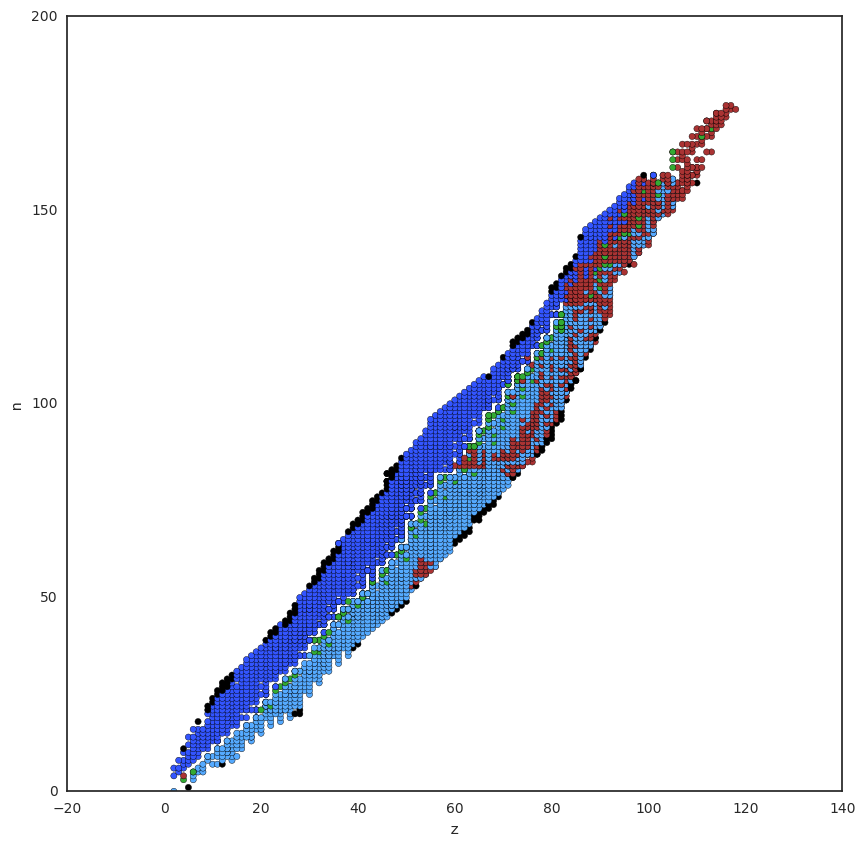

In [280]:
subset.plot.scatter('z', 'n', c=data[data.decay.isin(['β+','β−','α','EC',''])].decay.apply(lambda x:colors[x]),  ylim=(0,200), figsize=(10,10))

In [107]:
temp = []
            
for i in a:
    if a[i][0] is not None:
        temp.extend(list(a[i][0].columns))

In [123]:
trim_name = re.compile('(\(.*)')
set(trim_name.sub('', i.strip().lower().replace(' ', '_').replace('atomic_number', 'z')) for i in temp)

{'daughter_isotope',
 'decay_mode',
 'half-life',
 'historic_name',
 'isotopic_mass_',
 'n',
 'nuclear_spin',
 'nuclide_symbol',
 'range_of_natural_variation_',
 'representative_isotopic_composition_',
 'z'}

In [40]:
metastable_isotope.match('78mBr')

<_sre.SRE_Match object; span=(0, 5), match='78mBr'>

In [34]:
?json.dump